# Photogate explicado paso a paso

## Photogate y MotionDAQ

El [*photogate*](https://www.vernier.com/product/photogate/),
o fotosensor de barrera,
es un sensor que permite medir tiempos de manera muy precisa.
Para ello,
tiene un emisor de luz infrarroja
y un detector de luz.
Cuando detecta la luz infrarroja,
emite una señal de un dado voltaje.
Cuando un objeto atravieza el sensor,
bloquea la luz,
y el sensor emite otro voltaje.
Midiendo el tiempo cuando se produce el cambio de voltaje,
podemos saber cuando un objeto pasó por el *photogate*.

La señal del *photogate* la podemos digitalizar con el MotionDAQ.
Este mide el voltaje que emite el sensor
para un conjunto de tiempos discretos.
El tiempo $\Delta t$ entre mediciones se puede controlar,
elijiendo la frecuencia de muestreo $f = 1/\Delta t$.
Luego,
podemos exportar estas mediciones como un archivo de texto.

En este notebook,
vamos a ver como podemos cargar
y analizar esas mediciones para obtener los tiempos en que se bloqueó o desbloquó el sensor.

## Paquetes

Importamos los paquetes y funciones que vamos a necesitar:

- la función `Path` de `pathlib`,
  que nos permite manejar las "rutas" o ubicaciones de los archivos.
  En particular,
  la vamos a usar para encontrar todos los archivos de medición que usemos.
- `numpy`, para operar con arrays numéricos
- `matplotlib`, para graficar
- `pandas`, que solo vamos a usar para leer los archivos.
  Es muy usado porque proporciona varias comodidades sobre `numpy`,
  pero es confuso de usar al principio.

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Buscando los archivos

Buscamos todos los archivos que terminan con `.txt` en la carpeta actual.

:::{note}
Pueden decargar unos archivos de muestra de acá:
- [1cm.txt](https://github.com/maurosilber/python-tutorial/raw/main/book/laboratorio/photogate/1cm.txt)
- [2cm.txt](https://github.com/maurosilber/python-tutorial/raw/main/book/laboratorio/photogate/2cm.txt)
:::

### Para nuestro caso vamos a cargar los datos desde github 

In [10]:
url_1='https://raw.githubusercontent.com/KenetC/myt_verano24/main/DatosTaller2/datos1'
df = pd.read_csv(
    url_1,
    skiprows=3,  # que ignore las primeras 3 filas
    delimiter="\t",  # separador Tab
    decimal=",",  # coma decimal
)

## Cargando datos de un archivo

Si abrimos un archivo en un editor de texto (`notepad`),
veriamos lo siguiente:

In [ ]:
!head "datos3.txt"

date/time: ,20/02/2024,05:09 p.m.
Run 1

time	(V)
0,000000	4,588166E+0
0,005000	4,595705E+0
0,010000	4,588166E+0
0,015000	4,590679E+0
0,020000	4,585653E+0
0,025000	4,593192E+0


Es un archivo de texto,
donde las primeras dos filas tienen *metadata*:

- la hora a la que se tomó la medición, y
- número de corrida.

Las siguientes filas tienen los datos
agrupados en dos columnas,
que estan separadas por "un espacio".
En programación,
hay al menos dos tipos de espacios:

- `" "`, el espacio común que inserta la barra espaciadora, y
- `"\t"`, el espacio que inserta la tecla Tab.

En este caso,
es el segundo.

También,
los números usan una coma como separador decimal.

Todo esto hay que decirselo a Python,
para que sepa como interpretar el archivo.

### Sale NaN porque puse en la primer fila la long.

In [11]:
df

,time,(V)
0,78.500,NaN
1,0.000,4.491614
2,0.005,4.484083
3,0.010,4.479063
4,0.015,4.489104
...,...,...
4997,24.980,4.484083
4998,24.985,4.491614
4999,24.990,4.484083
5000,24.995,4.484083


La variable `df` tiene un `DataFrame` de `pandas`.
Podemos extraer el `array` de `numpy` interno con `df.values`:

In [16]:
data = df.values
L1 = data[0,0] 
L1

78.5

Este `array` tiene 996 filas y 2 columnas:

### Estos serian nuestros datos sin la long 

In [18]:
D = data[1:]

Para más (o menos) comodidad,
podemos separar cada una en una variable:

In [19]:
t = D[:, 0]  # tiempo [s]
v = D[:, 1]  # voltaje [V]
print(v)

[4.491614 4.484083 4.479063 ... 4.484083 4.484083 4.484083]


## Graficar los datos

Es importante visualizar los datos,
para asegurarnos de que no haya habido problemas de medición.
Grafiquemos estas dos variables:

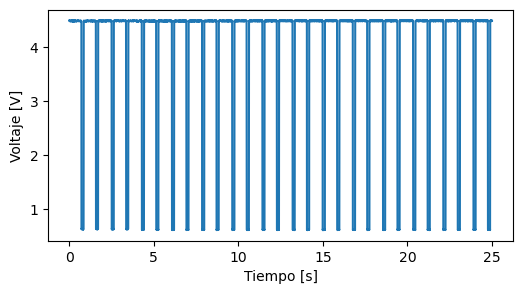

In [20]:
plt.figure(figsize=(6, 3))
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.plot(t, v)

Hagamos zoom sobre el primer salto,
y graficamos los valores discretos de la señal:

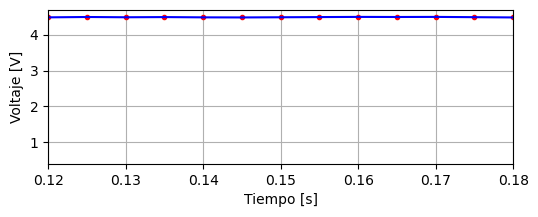

In [21]:
plt.figure(figsize=(6, 2))
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.plot(t, v,'r.')
plt.plot(t, v,'b')
#plt.plot(t, v, marker=".", color='r', linestyle="--")
plt.xlim(0.12, 0.18)
plt.grid()

### Preguntas

- ¿En qué tiempo se bloqueó el sensor?
- ¿Qué error podemos asignarle a ese tiempo?
- ¿Cómo podemos encontar "automaticamente" ese tiempo?
  ¿Qué distingue a esos tiempos de los demás?

## Calcular diferencias de voltaje

Para encontrar el cambio de voltaje,
podemos calcular la diferencia entre un punto $i$ y el siguiente $i+1$.
`numpy` incluye una función para esto: `np.diff`.

In [22]:
dif_de_v = np.diff(v)

Este vector tiene un valor menos el original,
ya que no puede calcular la diferencia del último con el siguiente
(¡ya no hay siguiente!).

In [23]:
np.size(v)

5001

In [24]:
np.size(dif_de_v)

5000

Para graficarlo,
vamos a ignorar el tiempo,
y dejar que grafique contra el número de indice del array:

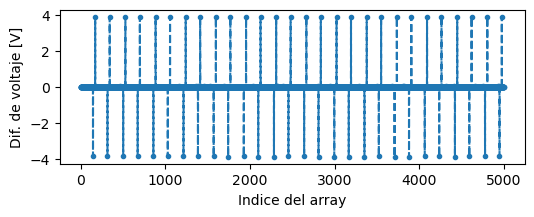

In [25]:
plt.figure(figsize=(6, 2))
plt.xlabel("Indice del array")
plt.ylabel("Dif. de voltaje [V]")
plt.plot(dif_de_v, marker=".", linestyle="--")

Si hacemos zoom al primer salto,
y superponemos la señal original,
podemos ver que da (practicamente) 0 en todos lados,
menos en los cambios de voltaje:

(0.0, 40.0)

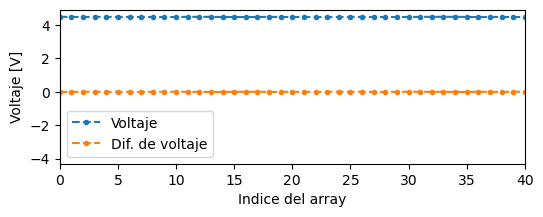

In [26]:
plt.figure(figsize=(6, 2))
plt.xlabel("Indice del array")
plt.ylabel("Voltaje [V]")
plt.plot(v, label="Voltaje", marker=".", linestyle="--")
plt.plot(dif_de_v, label="Dif. de voltaje", marker=".", linestyle="--")
plt.legend()
plt.xlim(0, 40)

Pero ojo,
no es exactamente 0,
ya que el voltaje fluctua levemente:

In [ ]:
v[:5]

array([4.588166, 4.595705, 4.588166, 4.590679, 4.585653])

In [ ]:
dif_de_v[:5]

array([ 0.007539, -0.007539,  0.002513, -0.005026,  0.007539])

## Encontrar valores que cumplen cierta condicion

Para encontrar los valores dentro de un `array` que cumplen cierta condicion,
se pueden hacer lo siguiente:

In [ ]:
y = np.array([0, 0, 5, 5, 0, 5])  # array de ejemplo

y > 3

array([False, False,  True,  True, False,  True])

que devuelve un vector de verdaderos (`True`) y falsos (`False`) para cada elemento.

Si quieren obtener las posiciones o indices donde se cumplió la condición,
es decir, donde están los `True`,
pueden hacer así:

In [ ]:
pos = np.nonzero(y > 3)

pos

(array([2, 3, 5]),)

Si quisieran extraer los valores de `y` que están en esas posiciones:

In [ ]:
y[pos]

array([5, 5, 5])

Entonces,
en el caso de la señal del fotosesnsor,
podemos encontrar los "saltos",
tanto positivos y negativos,
como:

In [27]:
pos = np.nonzero(np.abs(dif_de_v) > 2.5)

pos

(array([ 143,  169,  314,  340,  500,  526,  671,  697,  857,  883, 1027,
        1054, 1213, 1239, 1384, 1410, 1570, 1596, 1741, 1767, 1926, 1953,
        2097, 2124, 2283, 2309, 2454, 2480, 2640, 2666, 2810, 2837, 2996,
        3023, 3167, 3194, 3353, 3380, 3523, 3550, 3709, 3736, 3880, 3907,
        4066, 4093, 4237, 4264, 4423, 4450, 4593, 4620, 4779, 4806, 4950,
        4977]),)

Peor no nos interesa obtener el valor del voltaje en esas posiciones,
sino los tiempos en esas posiciones:

In [28]:
tiempo_saltos = t[pos]
Voltaje_saltos= v[pos]

tiempo_saltos

array([ 0.715,  0.845,  1.57 ,  1.7  ,  2.5  ,  2.63 ,  3.355,  3.485,
        4.285,  4.415,  5.135,  5.27 ,  6.065,  6.195,  6.92 ,  7.05 ,
        7.85 ,  7.98 ,  8.705,  8.835,  9.63 ,  9.765, 10.485, 10.62 ,
       11.415, 11.545, 12.27 , 12.4  , 13.2  , 13.33 , 14.05 , 14.185,
       14.98 , 15.115, 15.835, 15.97 , 16.765, 16.9  , 17.615, 17.75 ,
       18.545, 18.68 , 19.4  , 19.535, 20.33 , 20.465, 21.185, 21.32 ,
       22.115, 22.25 , 22.965, 23.1  , 23.895, 24.03 , 24.75 , 24.885])

# Para ver que valores encontramos y entender un poco mejor el dato


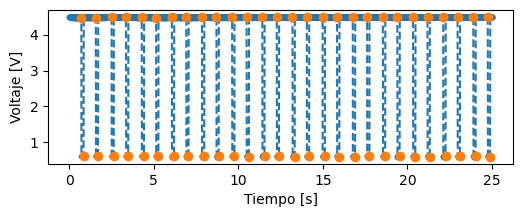

In [30]:
plt.figure(figsize=(6, 2))
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.plot(t, v, marker=".", linestyle="--")
plt.plot(tiempo_saltos, Voltaje_saltos, "o")

Igual que antes, hagamos zoom para ver mejor

(0.12, 0.18)

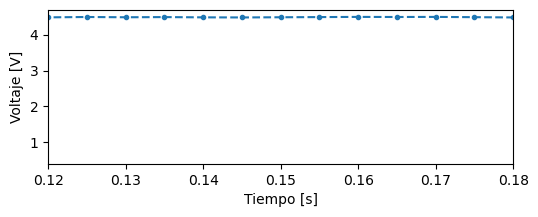

In [31]:
plt.figure(figsize=(6, 2))
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.plot(t, v, marker=".", linestyle="--")
plt.plot(tiempo_saltos, Voltaje_saltos, "o")
plt.xlim(0.12, 0.18)

¿Qué sucede? ¿Cómo encontramos el periodo?

## Encontrar periodos

Finalmente,
si nos interesa encontrar periodos,
podemos calcular las diferencias entre los tiempos correspondientes.
Esto dependerá del experimento.

Por ejemplo,
si necesitamos obtener 1 de cada 4 tiempos,
podemos tomar una "rebanada" (*slice*) del array con la siguiente expresion:

In [32]:
tiempo_saltos[::4]

array([ 0.715,  2.5  ,  4.285,  6.065,  7.85 ,  9.63 , 11.415, 13.2  ,
       14.98 , 16.765, 18.545, 20.33 , 22.115, 23.895])

En general,
la notación es `array[desde:hasta:paso]`.
Si omitimos uno,
por defecto son:

- `desde`: 0
- `hasta`: hasta el final
- `paso`: 1

Por ejemplo:

- `array[2:8:3]`
- `array[:5]`: hasta el 5to elemento.
- `array[10::3]`: desde el 10mo elemento cada 3.
- etc.

Luego,
podriamos calcular la diferencia entre valores consecutivos con:

In [33]:
np.diff(tiempo_saltos[::4])

array([1.785, 1.785, 1.78 , 1.785, 1.78 , 1.785, 1.785, 1.78 , 1.785,
       1.78 , 1.785, 1.785, 1.78 ])

## Más periodos

Para aprovechar todos los datos,
también pueden calcular los periodos cada 4,
pero empezando de la segunda medicion (indice 1):

In [34]:
np.diff(tiempo_saltos[1::4])

array([1.785, 1.785, 1.78 , 1.785, 1.785, 1.78 , 1.785, 1.785, 1.785,
       1.78 , 1.785, 1.785, 1.78 ])

Y desde la tercera y cuarta medicion.

Pueden hacer todo esto en un paso con la siguiente expresion:

In [35]:
tiempo_saltos[4:] - tiempo_saltos[:-4]

print('MEDIA:', np.mean(tiempo_saltos[4:] - tiempo_saltos[:-4]))
print('DESVIO:', np.std(tiempo_saltos[4:] - tiempo_saltos[:-4]))

MEDIA: 1.7832692307692306
DESVIO: 0.0023787147840099157


# Calculo del periodo
Una vez que tienen un arrange con todos los periodos. ¿Cón que valor se quedan?

Para eso volvemos a la primer clase (mediciones directas) y calculamos el periodo medio y su incerteza.

Les queda de ejercicio

Código original: https://maurosilber.github.io/python-tutorial/laboratorio/photogate/paso_a_paso.html
adaptado por Verónica Pérez Schuster, JTP laboratorio F1 (Q) para la cursada verano 2024

### Juntamos todo en un for para cada LONG, osea de data 1 a 10 

In [37]:
url = 'https://raw.githubusercontent.com/KenetC/myt_verano24/main/DatosTaller2/datos'
for i in range(1,11): 
    URL = url+str(i)
    df = pd.read_csv(
      URL,  # el primer archivo,
      skiprows=3,  # que ignore las primeras 3 filas
      delimiter="\t",  # separador Tab
      decimal=",",  # coma decimal
      )
    data = df.values
    #Long 
    L = data[0,0] 
    # datos de la long L
    D = data[1:]
    t = D[:, 0]  # tiempo [s]
    v = D[:, 1]
    dif_de_v = np.diff(v)
    pos = np.nonzero(np.abs(dif_de_v) > 2.5)
    tiempo_saltos = t[pos]
    Voltaje_saltos= v[pos]
    print('LONG: ', L)
    print('MEDIA:', np.mean(tiempo_saltos[4:] - tiempo_saltos[:-4]))
    print('DESVIO:', np.std(tiempo_saltos[4:] - tiempo_saltos[:-4]))

LONG:  78.5
MEDIA: 1.7832692307692306
DESVIO: 0.0023787147840099157
LONG:  68.5
MEDIA: 1.65625
DESVIO: 0.0021650635094610576
LONG:  84.0
MEDIA: 1.8640999999999999
DESVIO: 0.0019209372712298525
LONG:  54.5
MEDIA: 1.4782539682539682
DESVIO: 0.0023835964155050496
LONG:  70.8
MEDIA: 1.6894642857142856
DESVIO: 0.0015464739353290777
LONG:  30.0
MEDIA: 1.0973837209302322
DESVIO: 0.003118469379512403
LONG:  51.2
MEDIA: 1.4450000000000003
DESVIO: 0.0012403473458921684
LONG:  61.0
MEDIA: 1.5795833333333331
DESVIO: 0.0016562172428626453
LONG:  40.0
MEDIA: 1.2766216216216215
DESVIO: 0.0024807513176602295
LONG:  21.0
MEDIA: 0.9354807692307692
DESVIO: 0.0038927466307686347
